
# Practical Project (Convolutional Neural Networks)
           
This project is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this project, you will train a convolutional neural network to classify an image into one of two classes: "cat" or "dog". The code for the neural networks you train will be written for you, and you are not (yet!) expected to understand all provided code. However, by the end of the project, you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.

# Colab Link

Colab Link: https://colab.research.google.com/drive/1WyDhwTBbJt8iR3071zlTBRMPhU7uuBt0


In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

# Part 0. Helper Functions
We will be making use of the following helper functions. You will be asked to look at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code after making some progress on the project.

In [0]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Returns the indices for datapoints in the dataset that
    belongs to the desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_train_indices = get_relevant_indices(
            trainset,
            classes,
            target_classes)
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_train_indices)
    split = int(len(relevant_train_indices) * 0.8)
    relevant_train_indices, relevant_val_indices = relevant_train_indices[:split], relevant_train_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

# Part 1. Visualizing the Data

We will make use of some of the CIFAR-10 data set, which consists of colour images of size 32x32 pixels belonging to 10 categories. You can find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. We have included code that automatically downloads the dataset the first time that the main script is run.

In [0]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


# Part (a)
Visualize some of the data by running the code below. Include the visualization in your writeup.

(You don't need to submit anything else.)

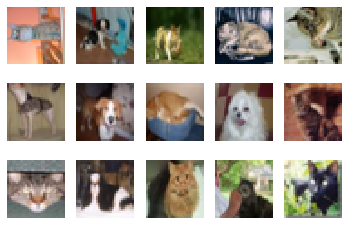

In [0]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

# Part (b)
How many training examples do we have for the combined cat and dog classes? What about validation examples? What about test examples? (insert text cell to answer it)

In [0]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

8000
2000
2000


1.   Number of training samples:8000
2.   number of validation examples:2000
3.   Number of test examples:2000

# Part (c)
Why do we need a validation set when training our model? What happens if we judge the performance of our models using the training set loss/error instead of the validation set loss/error? (insert text cell to answer it)

We use the training set to train our model. The validation set is using to create a stable model by tuning the hyperparameters. Using the validation set, we can evaluate the performance of our model for different hyperparameter values. If the hyperparameters are just optimized on the training set, it will lead to overfitting while using the test data set.

---

If we judge the performance of our models using the training set loss/error instead of the validation set loss/error, it may lead to overfitting. A fitted model usually adapts to training data, so its training error will be very low. Most of the cases the training error gradually decreases as the size of the model increases. Using the validation set, we can perform early stopping to create the minimum validation loss. 

# Part 2. Training
We define two neural networks, a LargeNet and SmallNet. We'll be training the networks in this section.

You won't understand fully what these networks are doing until the next few classes, and that's okay. For this assignment, please focus on learning how to train networks, and how hyperparameters affect training.

In [0]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
small_net = SmallNet()
large_net = LargeNet()

# Part (2a)
The methods small_net.parameters() and large_net.parameters() produces an iterator of all the trainable parameters of the network. These parameters are torch tensors containing many scalar values.

We haven't learned how the parameters in these high-dimensional tensors will be used, but we should be able to count the number of parameters. Measuring the number of parameters in a network is one way of measuring the "size" of a network.

What is the total number of parameters in small_net and in large_net? (Hint: how many numbers are in each tensor?)

(insert text cell to answer it)

In [0]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


In [0]:
model_path = get_model_name(small_net, batch_size=64, learning_rate=0.01, epoch=30)
model_path

'model_SmallNet(\n  (conv): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))\n  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (fc): Linear(in_features=245, out_features=1, bias=True)\n)_bs64_lr0.01_epoch30'

In [0]:
from torchsummary import summary
summary(small_net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 30, 30]             140
         MaxPool2d-2            [-1, 5, 15, 15]               0
         MaxPool2d-3              [-1, 5, 7, 7]               0
            Linear-4                    [-1, 1]             246
Total params: 386
Trainable params: 386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 0.00
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [0]:
pytorch_total_params = sum(p.numel() for p in small_net.parameters())
pytorch_total_params

386

Total number of parameters in Small_net:386

In [0]:
for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


In [0]:
model_path = get_model_name(large_net, batch_size=64, learning_rate=0.01, epoch=30)
model_path

'model_LargeNet(\n  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))\n  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))\n  (fc1): Linear(in_features=250, out_features=32, bias=True)\n  (fc2): Linear(in_features=32, out_features=1, bias=True)\n)_bs64_lr0.01_epoch30'

In [0]:
from torchsummary import summary
summary(large_net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 28, 28]             380
         MaxPool2d-2            [-1, 5, 14, 14]               0
            Conv2d-3           [-1, 10, 10, 10]           1,260
         MaxPool2d-4             [-1, 10, 5, 5]               0
            Linear-5                   [-1, 32]           8,032
            Linear-6                    [-1, 1]              33
Total params: 9,705
Trainable params: 9,705
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.04
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [0]:
pytorch_total_params = sum(p.numel() for p in large_net.parameters())
pytorch_total_params

9705

Total number of parameters in large_net:9705

# The function train_net

The function train_net below takes an untrained neural network (like small_net and large_net) and several other parameters. You should be able to understand how this function works. The figure below shows the high level training loop for a machine learning model:



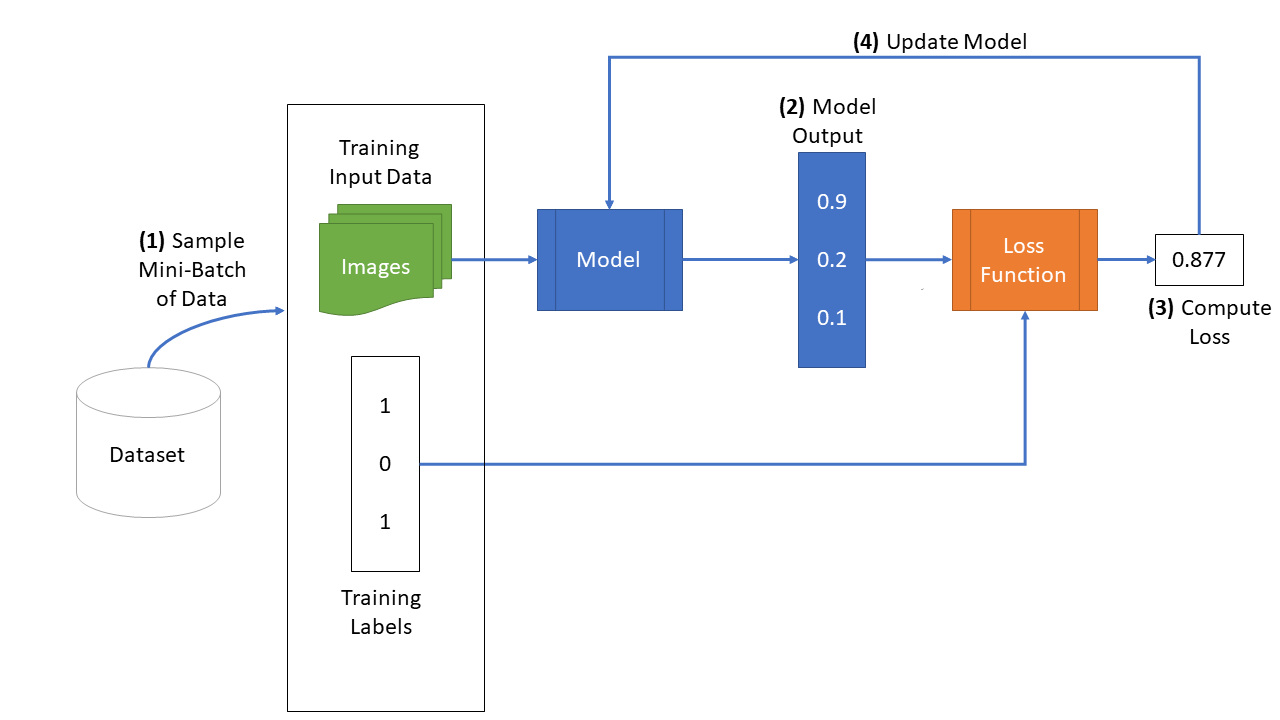

In [0]:
from IPython.display import Image
Image('NN.png',  width=800, height=500)

In [0]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

# Part (b)
The parameters to the function train_net are hyperparameters of our neural network. We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters batch_size, learning_rate, and num_epochs? (insert text cell/section header cell to answer)


1.   batch_size=64
2.   learning_rate=0.01
3. num_epochs=30


# Part (c)
What files are written to disk when we call train_net with small_net, and train for 5 epochs? Provide a list of all the files written to disk, and what information the files contain.(insert text cell/section header cell to answer)

In [0]:
train_net(net=small_net, batch_size=64, learning_rate=0.01, num_epochs=5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4225, Train loss: 0.6717527275085449 |Validation err: 0.3805, Validation loss: 0.6561870202422142
Epoch 2: Train err: 0.36625, Train loss: 0.6461773118972778 |Validation err: 0.3655, Validation loss: 0.6487357430160046
Epoch 3: Train err: 0.348375, Train loss: 0.6315064954757691 |Validation err: 0.337, Validation loss: 0.6204650849103928
Epoch 4: Train err: 0.337, Train loss: 0.6175585942268371 |Validation err: 0.3555, Validation loss: 0.6252859104424715
Epoch 5: Train err: 0.33075, Train loss: 0.6081118950843811 |Validation err: 0.3245, Validation loss: 0.6142133250832558
Finished Training
Total time elapsed: 17.59 seconds


The train_net will save four different files to the disk for each epoch.
The files are : 
Train err
Train loss
Validation err
Validation loss

Train loss is the value of loss function in each epoch for the training data set. The loss function is a continues differentiable function defined based on the backpropagation algorithm. CNN will train to minimize the loss value. the loss value can be positive or negative based on the corresponding to the objective function. Same way, validation loss is the value of loss function for the validation data set.
Train error is the measurement of what percentage of the training example our model gets incorrect. Train error is always between zero and one. The validation error is the corresponding error measurement in the validation dataset.

The training error and loss are measured and recorded on the training set. The validation error and loss will calculated when we ran the validation set through the trained model. 

In other words, the error is the difference between actual/true value and predicted value. the loss is the measure of how well a model fits the data.

# Part (d)
Train both small_net and large_net using the function train_net and its default parameters. The function will write many files to disk, including a model checkpoint (saved values of model weights) at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive so that the files generated by train_net gets saved. We will be using these files in part (d). (See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train? Why?

In [0]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train_net(net=small_net, batch_size=64, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.320125, Train loss: 0.6008959922790528 |Validation err: 0.333, Validation loss: 0.608821077272296
Epoch 2: Train err: 0.317625, Train loss: 0.5932810437679291 |Validation err: 0.333, Validation loss: 0.6089066360145807
Epoch 3: Train err: 0.312125, Train loss: 0.5906731638908386 |Validation err: 0.324, Validation loss: 0.6025739936158061
Epoch 4: Train err: 0.313125, Train loss: 0.5859340348243713 |Validation err: 0.3305, Validation loss: 0.605708658695221
Epoch 5: Train err: 0.304875, Train loss: 0.5796232364177704 |Validation err: 0.315, Validation loss: 0.5994461607187986
Epoch 6: Train err: 0.301375, Train loss: 0.574746855020523 |Validation err: 0.329, Validation loss: 0.6017599040642381
Epoch 7: Train err: 0.3015, Train loss: 0.5731864838600159 |Validation err: 0.327, Validation loss: 0.5917336512356997
Epoch 8: Train err: 0.295875, Train loss: 0.5678402397632599 |Validation err: 0.3

In [0]:
train_net(net=large_net, batch_size=64, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.466125, Train loss: 0.6921264848709107 |Validation err: 0.437, Validation loss: 0.6872521843761206
Epoch 2: Train err: 0.440125, Train loss: 0.6837422437667847 |Validation err: 0.42, Validation loss: 0.676597885787487
Epoch 3: Train err: 0.4105, Train loss: 0.670060254573822 |Validation err: 0.3855, Validation loss: 0.6545403730124235
Epoch 4: Train err: 0.37725, Train loss: 0.6512780785560608 |Validation err: 0.3955, Validation loss: 0.648885827511549
Epoch 5: Train err: 0.347, Train loss: 0.6257636995315552 |Validation err: 0.338, Validation loss: 0.6165360081940889
Epoch 6: Train err: 0.322, Train loss: 0.6000606725215912 |Validation err: 0.3535, Validation loss: 0.6294178776443005
Epoch 7: Train err: 0.319125, Train loss: 0.5931247260570526 |Validation err: 0.3365, Validation loss: 0.6092451587319374
Epoch 8: Train err: 0.303125, Train loss: 0.5755596787929534 |Validation err: 0.3215, 

In [0]:
!ls

data
gdrive
model_large_bs64_lr0.01_epoch0
model_large_bs64_lr0.01_epoch1
model_large_bs64_lr0.01_epoch10
model_large_bs64_lr0.01_epoch11
model_large_bs64_lr0.01_epoch12
model_large_bs64_lr0.01_epoch13
model_large_bs64_lr0.01_epoch14
model_large_bs64_lr0.01_epoch15
model_large_bs64_lr0.01_epoch16
model_large_bs64_lr0.01_epoch17
model_large_bs64_lr0.01_epoch18
model_large_bs64_lr0.01_epoch19
model_large_bs64_lr0.01_epoch2
model_large_bs64_lr0.01_epoch20
model_large_bs64_lr0.01_epoch21
model_large_bs64_lr0.01_epoch22
model_large_bs64_lr0.01_epoch23
model_large_bs64_lr0.01_epoch24
model_large_bs64_lr0.01_epoch25
model_large_bs64_lr0.01_epoch26
model_large_bs64_lr0.01_epoch27
model_large_bs64_lr0.01_epoch28
model_large_bs64_lr0.01_epoch29
model_large_bs64_lr0.01_epoch29_train_err.csv
model_large_bs64_lr0.01_epoch29_train_loss.csv
model_large_bs64_lr0.01_epoch29_val_err.csv
model_large_bs64_lr0.01_epoch29_val_loss.csv
model_large_bs64_lr0.01_epoch3
model_large_bs64_lr0.01_epoch4
model_large

Training Time of large_net: 118.76 seconds.

Training time of small_net: 103.22 seconds.

The training time of large_net is higher than the small net. 
The small_net is consists of 386 parameters while the large network consists of 9705 parameters. Based on the number of parameters, the large_net is the bigger model than the small_net. Here the large_net has convolution with bigger filters and requires more calculations. The small_net has only two filters (1 convolutional and 1 fully connected) hence doing fewer convolutions.

# Part (e)
Use the function plot_training_curve to display the trajectory of the training/validation error and the training/validation loss. You will need to use the function get_model_name to generate the argument to the plot_training_curve function.

Do this for both the small network and the large network. Include both plots in your writeup. 

(include in your colab) you can use the following code to insert any images/plots to your colab 

from google.colab import files

uploaded = files.upload()

from IPython.display import Image 

Image('NN.png',  width=800, height=500)

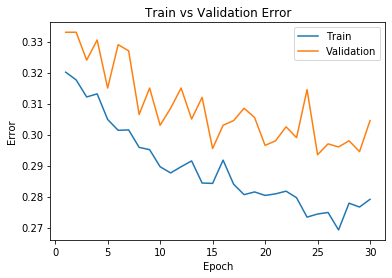

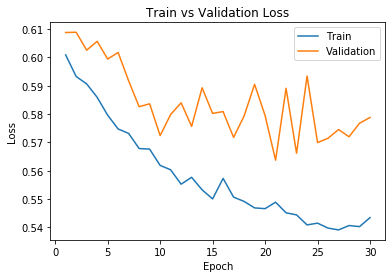

In [0]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

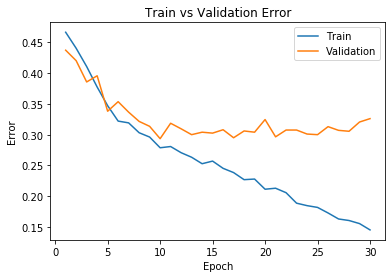

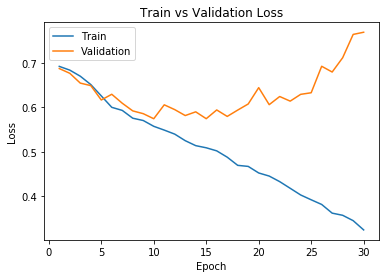

In [0]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

# Part (f)
Describe what you notice about the training curve. How do the curves differ for small_net and large_net? Identify any occurences of underfitting and overfitting.

A learning curve is a diagnostic tool using to evaluate the performance of a model. Here we are using loss and error plots between training and validation sets. A learning curve is a plot with time or experience on the x-axis and learning or improvement on the y-axis.

The underfit refers to a model that can not learn the training dataset.  If the model is underfitting the training loss will be almost a flat line or decreasing to the end of the plot after reaching the saturation. Overfitting means a model learned the training data very well but poor predictability and classification efficiency with new data. The generalization ability of an overfit model is very less. In a good fit model, the training and validation loss will decrease to a point of stability with a minimum gap between them.

Here in small_net, train loss/error is decreasing gradually and reaching a satuaration. Hence there is no underfitting in the model but the validation loss/error is higher than the training loss/error. So it may be a case of overfitting.

In large_net, the training loss is decreasing gradually and reaching a minimum value after a sharp fall. So the training model is learning well on the training data. Even though the validation loss/error is increased abruptly after the 10th epoch and there exists a huge difference between train and validation plots after the 10th epoch, so this is also a case of overfitting.

# Part 3. Optimization Parameters
For this section, we will work with large_net only.

# Part (a)
Train large_net with all default parameters, except set learning_rate=0.001. Does the model take longer/shorter to train? Plot the training curve. Describe the effect of lowering the learning rate.

In [0]:
large_net = LargeNet()
train_net(net=large_net, batch_size=64, learning_rate=0.001, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360023498535 |Validation err: 0.467, Validation loss: 0.6924686655402184
Epoch 2: Train err: 0.448625, Train loss: 0.6922589688301086 |Validation err: 0.4305, Validation loss: 0.6916493382304907
Epoch 3: Train err: 0.43575, Train loss: 0.6916067261695862 |Validation err: 0.4285, Validation loss: 0.6908544152975082
Epoch 4: Train err: 0.43, Train loss: 0.6908614072799683 |Validation err: 0.4245, Validation loss: 0.6896600145846605
Epoch 5: Train err: 0.434375, Train loss: 0.689919647693634 |Validation err: 0.4195, Validation loss: 0.6886944100260735
Epoch 6: Train err: 0.435875, Train loss: 0.6887412457466126 |Validation err: 0.4195, Validation loss: 0.6867826543748379
Epoch 7: Train err: 0.43675, Train loss: 0.6873777341842652 |Validation err: 0.418, Validation loss: 0.6851988434791565
Epoch 8: Train err: 0.437375, Train loss: 0.6859265742301941 |Validation err: 0.

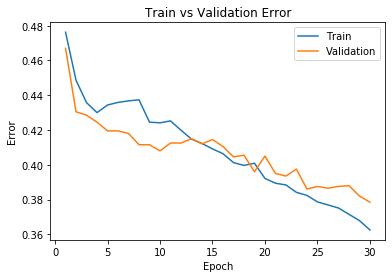

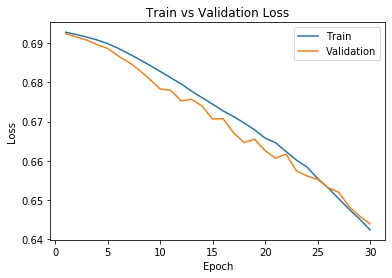

In [0]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

The learning rate is a hyperparameter that defines the degree of change in weights of each neuron to minimize the error. The learning rate decides how quickly the model is adapted to a problem. Small learning rates required more training epochs and fewer training epochs for larger learning rates.

Here the training time is 120.71 seconds which is higher than the model with the learning rate 0.01. When the learning rate decreased, the training time of the large_net increased. From the plot, we can see that the performance of the model is increased after lowering the learning rate. The difference between training and validation plot is decreased and the generalization ability of the model is increased. 

# Part (b)
Train large_net with all default parameters, except set learning_rate=0.1. Does the model take longer/shorter to train? Plot the training curve. Describe the effect of increasing the learning rate.

In [0]:
large_net = LargeNet()
train_net(net=large_net, batch_size=64, learning_rate=0.1, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426875, Train loss: 0.6742900676727295 |Validation err: 0.3695, Validation loss: 0.6364889536052942
Epoch 2: Train err: 0.361625, Train loss: 0.6373908457756042 |Validation err: 0.3655, Validation loss: 0.6439082939177752
Epoch 3: Train err: 0.371625, Train loss: 0.6370397086143493 |Validation err: 0.3515, Validation loss: 0.6133540160953999
Epoch 4: Train err: 0.348, Train loss: 0.6141975626945496 |Validation err: 0.3365, Validation loss: 0.6044933125376701
Epoch 5: Train err: 0.333875, Train loss: 0.6029216282367706 |Validation err: 0.3245, Validation loss: 0.5935317613184452
Epoch 6: Train err: 0.3175, Train loss: 0.5871682240962982 |Validation err: 0.324, Validation loss: 0.5884642750024796
Epoch 7: Train err: 0.308, Train loss: 0.5718630583286285 |Validation err: 0.3095, Validation loss: 0.5934673277661204
Epoch 8: Train err: 0.306625, Train loss: 0.5659790558815002 |Validation err: 0

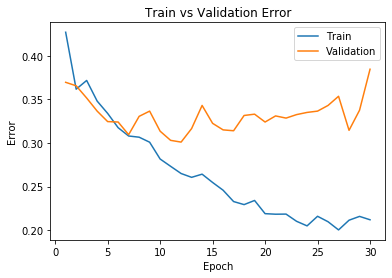

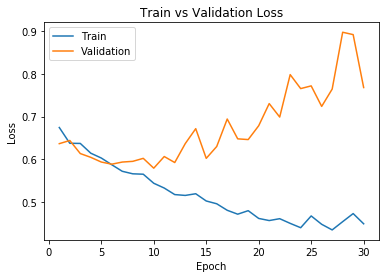

In [0]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path)

The learning time of the large_net is decreased after increasing the learning rate. The degree of overfitting is increased with an increase in the learning rate by keeping the hyperparameters default. Here increasing the batch size or decreasing the number of epochs may be helpful to create an optimal model. The learning rate that is too large can cause the model to converge too quickly to a suboptimal solution.

# Part (c)
Train large_net with all default parameters, including with learning_rate=0.01. Now, set batch_size=512. Does the model take longer/shorter to train? Plot the training curve. Describe the effect of increasing the batch size.

In [0]:
large_net = LargeNet()
train_net(net=large_net, batch_size=512, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379403591156 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500441730022 |Validation err: 0.4265, Validation loss: 0.6909130066633224
Epoch 4: Train err: 0.433625, Train loss: 0.6908450052142143 |Validation err: 0.424, Validation loss: 0.6897870898246765
Epoch 5: Train err: 0.434, Train loss: 0.6896936446428299 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883534081280231 |Validation err: 0.428, Validation loss: 0.68601293861866
Epoch 7: Train err: 0.439375, Train loss: 0.6866869702935219 |Validation err: 0.426, Validation loss: 0.6836968064308167
Epoch 8: Train err: 0.435375, Train loss: 0.6849769502878189 |Validation err: 0.412, V

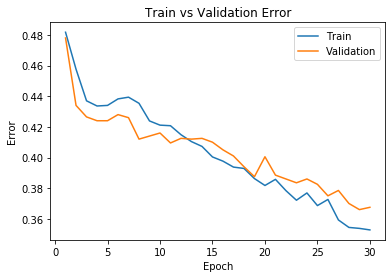

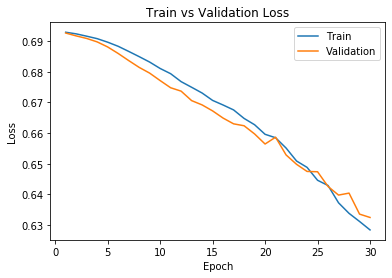

In [0]:
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

A batch size of X means, X samples from the training dataset will be used to estimate the error gradient before the model weights are updated. Too large batch size will leads to poor generalization and reduces the validation quality of the model.

Here, the training time of this large_net model is 109.58 seconds, which is lower than the previous large_net models. When we increased the batch size, the time of training decreased, which may be of faster leaning efficiency of the model with a large batch size. The gap between the training loss/error and validation loss/error curves is minimum thus it is a model with minimum overfitting and increased efficiency.

All the above learning plots of large_net provided here lack a point of saturation. This may be an indication need for further learning and window of improvements.

# Part (d)
Train large_net with all default parameters, including with learning_rate=0.01. Now, set batch_size=16. Does the model take longer/shorter to train? Plot the training curve. Describe the effect of decreasing the batch size.

In [0]:
large_net = LargeNet()
train_net(net=large_net, batch_size=16, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774821187257767 |Validation err: 0.378, Validation loss: 0.651921395778656
Epoch 2: Train err: 0.36875, Train loss: 0.6395755406022072 |Validation err: 0.3595, Validation loss: 0.6264406447410583
Epoch 3: Train err: 0.33875, Train loss: 0.6120929001569748 |Validation err: 0.3475, Validation loss: 0.6289729187488556
Epoch 4: Train err: 0.314375, Train loss: 0.5869516692757607 |Validation err: 0.3545, Validation loss: 0.6142054274082184
Epoch 5: Train err: 0.3115, Train loss: 0.5694829801917076 |Validation err: 0.312, Validation loss: 0.5763112711906433
Epoch 6: Train err: 0.281125, Train loss: 0.5458917077481746 |Validation err: 0.2985, Validation loss: 0.5741617560386658
Epoch 7: Train err: 0.269875, Train loss: 0.5297637034058571 |Validation err: 0.309, Validation loss: 0.6013907868862152
Epoch 8: Train err: 0.257375, Train loss: 0.5129605046510697 |Validation err: 0

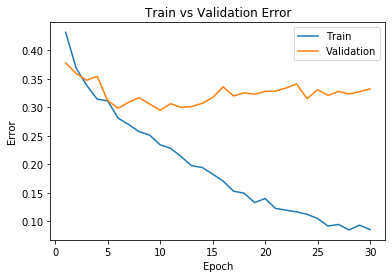

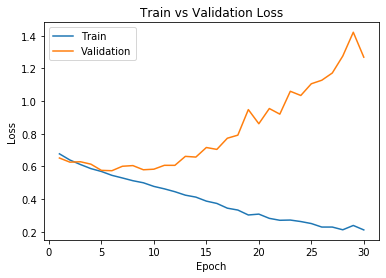

In [0]:
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

Here the training time of the large_net model is 174.64 seconds, which is higher than all previous large net models. The batch size of the model has an inverse effect on the training time and learning speed of the model. The training time increased with a decrease in the batch size. From the learning curve, it is clear that the model is overfitting and the generalization ability of the model is reduced. The steep decrease in the loss and error value of the training set is an indication that the model is loo well on the training set.

# Part 4. Hyperparameter Search
# Part (a)
Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate) that you think would help you improve the validation accuracy. Justify your choice.

batch_size=512.

learning_rate=0.001

Analyzing the previous large_net models we can observe comparatively optimal performance and least overfitting for models with batch-size 512 and learning rate 0.001. So we can presume that this particular model with specified hyperparameter values will have less overfitting and good generalization efficiency. 

# Part (b)
Train the model with the hyperparameters you chose in part(a), and include the training curve

In [0]:
large_net = LargeNet()
train_net(net=large_net, batch_size=512, learning_rate=0.001, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677443742752 |Validation err: 0.4955, Validation loss: 0.6931362003087997
Epoch 2: Train err: 0.483125, Train loss: 0.6929955184459686 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280459880829 |Validation err: 0.493, Validation loss: 0.6929539293050766
Epoch 4: Train err: 0.477, Train loss: 0.6928808465600014 |Validation err: 0.4885, Validation loss: 0.6928706467151642
Epoch 5: Train err: 0.473375, Train loss: 0.6927744224667549 |Validation err: 0.4835, Validation loss: 0.6927504688501358
Epoch 6: Train err: 0.469, Train loss: 0.6926896125078201 |Validation err: 0.472, Validation loss: 0.6926551759243011
Epoch 7: Train err: 0.46325, Train loss: 0.6926203668117523 |Validation err: 0.47, Validation loss: 0.6925524771213531
Epoch 8: Train err: 0.46225, Train loss: 0.6925435625016689 |Validation err: 0.463

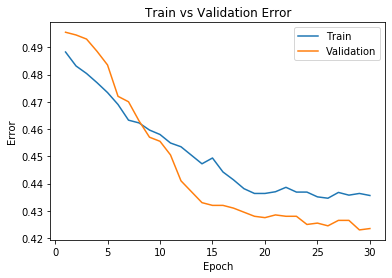

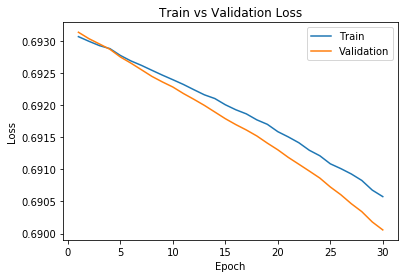

In [0]:
model_path = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

Here validation loss is lower than the training loss. This is a case of unknown fit. 

# Part (c)
Based on your result from Part(a), suggest another set of hyperparameter values to try. Justify your choice.

batch_size=512.

learning_rate=0.001

epoch= 180

To create a efficient model with lower learning rate, we should increase the number of epch. 


# Part (d)
Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [0]:
large_net = LargeNet()
train_net(net=large_net, batch_size=512, learning_rate=0.001, num_epochs=180)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.546125, Train loss: 0.6953096762299538 |Validation err: 0.543, Validation loss: 0.6954735219478607
Epoch 2: Train err: 0.545125, Train loss: 0.6951569058001041 |Validation err: 0.548, Validation loss: 0.6952388137578964
Epoch 3: Train err: 0.5445, Train loss: 0.694941122084856 |Validation err: 0.55, Validation loss: 0.6949708014726639
Epoch 4: Train err: 0.542625, Train loss: 0.6947613395750523 |Validation err: 0.5445, Validation loss: 0.6947506219148636
Epoch 5: Train err: 0.540625, Train loss: 0.6945716217160225 |Validation err: 0.548, Validation loss: 0.6945213377475739
Epoch 6: Train err: 0.536625, Train loss: 0.6943864896893501 |Validation err: 0.539, Validation loss: 0.6943320035934448
Epoch 7: Train err: 0.535625, Train loss: 0.694232452660799 |Validation err: 0.54, Validation loss: 0.6941453814506531
Epoch 8: Train err: 0.52975, Train loss: 0.6940469108521938 |Validation err: 0.532

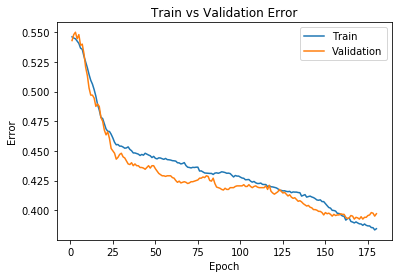

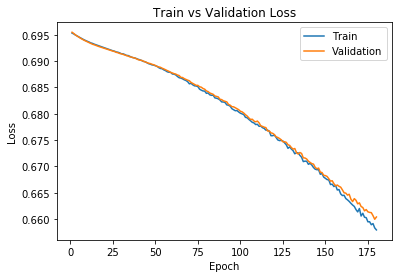

In [0]:
model_path = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=179)
plot_training_curve(model_path)